## Laboratoria 3.3. Optymalizacja wag w sieci MLP z użyciem algorytmu genetycznego

## [Zadanie](https://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-gen.html)

Zaimplementować proste uczenie MLP z użyciem algorytmu genetycznego. Na wejściu jest: struktura sieci neuronowej i dane uczące. Optymalizowana funkcja to funkcja przekształcająca wektor wag sieci na błąd na zbiorze uczącym. Zastosować standardowe operatory krzyżowania i mutacji.

Przeprowadzić uczenie na zbiorach:

- iris https://archive.ics.uci.edu/ml/datasets/Iris
- multimodal-large (z części laboratorium o sieciach neuronowych)
- auto-mpg (przewidzieć wartość mpg) - http://archive.ics.uci.edu/ml/datasets/Auto+MPG

In [1]:
import math
import matplotlib.pyplot as plt
import numpy
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import random

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
class Activations:
    @staticmethod
    def sigmoid(x):
        return 1.0/(1.0+numpy.exp(-x))
    @staticmethod
    def relu(x):
        result = x
        result[x < 0] = 0
        return result

class Transformations:
    @staticmethod
    def matr_to_vect(weights_matr):
        weights_vect = []
        for idx in range(weights_matr.shape[0]):
            curr_vect = []
            for layer_idx in range(weights_matr.shape[1]):
                vector_weights = numpy.reshape(weights_matr[idx, layer_idx], newshape=(weights_matr[idx, layer_idx].size))
                curr_vect.extend(vector_weights)
            weights_vect.append(curr_vect)
        return numpy.array(weights_vect)
    
    @staticmethod
    def vect_to_mat(weights_vect, weights_matr):
        mat_weights = []
        for idx in range(weights_matr.shape[0]):
            start = 0
            end = 0
            for layer_idx in range(weights_matr.shape[1]):
                end = end + weights_matr[idx, layer_idx].size
                curr_vect = weights_vect[idx, start:end]
                mat_layer_weights = numpy.reshape(curr_vect, newshape=(weights_matr[idx, layer_idx].shape))
                mat_weights.append(mat_layer_weights)
                start = end
        return numpy.reshape(mat_weights, newshape=weights_matr.shape)

In [3]:
class MLP_with_GA:
    def __init__(self, layers, population_size, k=4, num_generations=1000, mutation_ratio = 0.1, classif=True):
        self.layers = layers
        self.population_size = population_size
        self.k = k
        self.num_generations = num_generations
        self.mutation_ratio = mutation_ratio
        self.classif = classif
        
    def initialize_weights(self):
        initial_weights = []
        for i in numpy.arange(0, self.population_size):
            tmp = []
            for j in range(1, len(self.layers)):
                tmp.append(numpy.random.uniform(low=-0.1, high=0.1, size=(self.layers[j-1], self.layers[j])))

            initial_weights.append(numpy.array(tmp))
        self.initial_weights = initial_weights
        
    def selection(self, population, score):
        parents = numpy.empty((self.k, population.shape[1]))
        for parent_num in range(self.k):
            if self.classif:
                best_idx = numpy.where(score == numpy.max(score))
            else:
                best_idx = numpy.where(score == numpy.min(score))

            best_idx = best_idx[0][0]
            parents[parent_num, :] = population[best_idx, :]

            if self.classif:
                score[best_idx] = -math.inf
            else:
                score[best_idx] = math.inf
        return parents
                
    def crossover(self, parents, children_set_size):
            children = numpy.empty(children_set_size)
            crossover_point = numpy.uint32(children_set_size[1]/2)

            for k in range(children_set_size[0]):
                parent1_idx = k%parents.shape[0]
                parent2_idx = (k+1)%parents.shape[0]
                children[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
                children[k, crossover_point:] = parents[parent2_idx, crossover_point:]
            return children
        
    def mutation(self, children):
        mutations_number = numpy.uint32((self.mutation_ratio*children.shape[1]))
        mutation_idxs = numpy.array(random.sample(range(0, children.shape[1]), mutations_number))
        # Mutation changes a single gene in each offspring randomly.
        for idx in range(children.shape[0]):
            # The random value to be added to the gene.
            rand = numpy.random.uniform(-1.0, 1.0, 1)
            children[idx, mutation_idxs] = children[idx, mutation_idxs] + rand
        return children
    
    def predict(self, weights_matr, data_in, data_out, activation="sigmoid"):
        predictions = numpy.zeros(shape=(data_in.shape[0]))
        for sample_idx in range(data_in.shape[0]):
            indiv = data_in.iloc[sample_idx, :]
            for curr_weights in weights_matr:
                indiv = numpy.matmul(indiv, curr_weights)
                if activation == "relu":
                    indiv = Activations.relu(indiv)
                elif activation == "sigmoid":
                    indiv = Activations.sigmoid(indiv)
            if self.classif:
                predicted_label = numpy.where(indiv == numpy.max(indiv))[0][0]
                predictions[sample_idx] = predicted_label
            else: 
                predictions[sample_idx] = indiv
        if self.classif:
            score = accuracy_score(data_out, predictions)
        else:
            score = mean_squared_error(data_out, predictions)
                
        return score, predictions

    def fit(self, weights_matr, data_in, data_out, activation="relu"):
        score = numpy.empty(shape=(weights_matr.shape[0]))
        for idx in range(weights_matr.shape[0]):
            curr = weights_matr[idx, :]
            score[idx], _ = self.predict(curr, data_in, data_out, activation=activation)
        return score
    
    def train(self, data_in, data_out):
        self.initialize_weights()
        weights_matr = numpy.array(self.initial_weights)
        weights_vect = Transformations.matr_to_vect(weights_matr)

        best_outputs = []
        scores = numpy.empty(shape=(self.num_generations))
        
        for generation in range(self.num_generations):
            print("Generation : ", generation)
            weights_matr = Transformations.vect_to_mat(weights_vect, weights_matr)
            score = self.fit(weights_matr, data_in, data_out, activation="sigmoid")
            scores[generation] = score[0]
            parents = self.selection(weights_vect, score.copy())
            crossover_result = self.crossover(parents, children_set_size=(weights_vect.shape[0]-parents.shape[0], weights_vect.shape[1]))
            mutation_result = self.mutation(crossover_result)

            # New population based on the parents and children creation
            weights_vect[0:parents.shape[0], :] = parents
            weights_vect[parents.shape[0]:, :] = mutation_result
            
        weights_matr = Transformations.vect_to_mat(weights_vect, weights_matr)
        best_weights = weights_matr[0, :]
        fitness_score, predictions = self.predict(best_weights, data_in, data_out, activation="sigmoid")
        print("The best solution fitness score is : ", fitness_score)
        return scores

## Iris dataset

In [4]:
iris = pd.read_csv("../data/mio3/iris.data",header=None)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
iris.iloc[:,4] = le.fit_transform(iris.iloc[:,4])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    iris.iloc[:,0:4], iris.iloc[:,4], test_size=0.33, random_state=42)

In [5]:
mlp1 = MLP_with_GA(layers=[4, 150, 60, 3], population_size=20, num_generations=1000)

In [6]:
scores1 = mlp1.train(X_train, y_train)

Generation :  0
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Generation :  9
Generation :  10
Generation :  11
Generation :  12
Generation :  13
Generation :  14
Generation :  15
Generation :  16
Generation :  17
Generation :  18
Generation :  19
Generation :  20
Generation :  21
Generation :  22
Generation :  23
Generation :  24
Generation :  25
Generation :  26
Generation :  27
Generation :  28
Generation :  29
Generation :  30
Generation :  31
Generation :  32
Generation :  33
Generation :  34
Generation :  35
Generation :  36
Generation :  37
Generation :  38
Generation :  39
Generation :  40
Generation :  41
Generation :  42
Generation :  43
Generation :  44
Generation :  45
Generation :  46
Generation :  47
Generation :  48
Generation :  49
Generation :  50
Generation :  51
Generation :  52
Generation :  53
Generation :  54
Generation :  55
Generation :  56
Generation :  57
Generation :  58
Generat

Generation :  462
Generation :  463
Generation :  464
Generation :  465
Generation :  466
Generation :  467
Generation :  468
Generation :  469
Generation :  470
Generation :  471
Generation :  472
Generation :  473
Generation :  474
Generation :  475
Generation :  476
Generation :  477
Generation :  478
Generation :  479
Generation :  480
Generation :  481
Generation :  482
Generation :  483
Generation :  484
Generation :  485
Generation :  486
Generation :  487
Generation :  488
Generation :  489
Generation :  490
Generation :  491
Generation :  492
Generation :  493
Generation :  494
Generation :  495
Generation :  496
Generation :  497
Generation :  498
Generation :  499
Generation :  500
Generation :  501
Generation :  502
Generation :  503
Generation :  504
Generation :  505
Generation :  506
Generation :  507
Generation :  508
Generation :  509
Generation :  510
Generation :  511
Generation :  512
Generation :  513
Generation :  514
Generation :  515
Generation :  516
Generation

Generation :  918
Generation :  919
Generation :  920
Generation :  921
Generation :  922
Generation :  923
Generation :  924
Generation :  925
Generation :  926
Generation :  927
Generation :  928
Generation :  929
Generation :  930
Generation :  931
Generation :  932
Generation :  933
Generation :  934
Generation :  935
Generation :  936
Generation :  937
Generation :  938
Generation :  939
Generation :  940
Generation :  941
Generation :  942
Generation :  943
Generation :  944
Generation :  945
Generation :  946
Generation :  947
Generation :  948
Generation :  949
Generation :  950
Generation :  951
Generation :  952
Generation :  953
Generation :  954
Generation :  955
Generation :  956
Generation :  957
Generation :  958
Generation :  959
Generation :  960
Generation :  961
Generation :  962
Generation :  963
Generation :  964
Generation :  965
Generation :  966
Generation :  967
Generation :  968
Generation :  969
Generation :  970
Generation :  971
Generation :  972
Generation

Text(0, 0.5, 'Fitness')

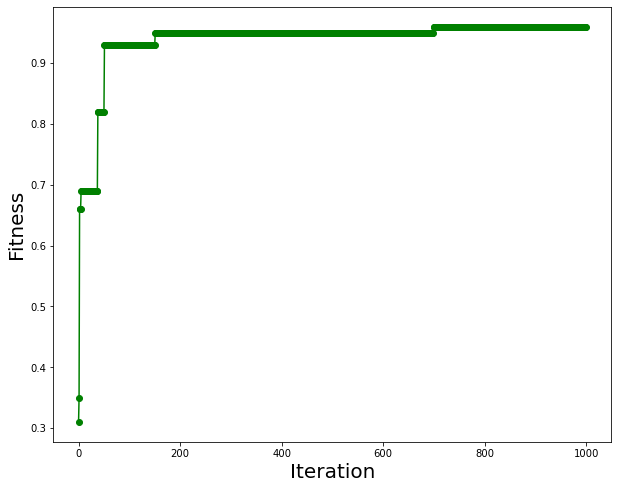

In [7]:
plt.plot(scores1, '-og')
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("Fitness", fontsize=20)

# Multimodal large dataset

In [8]:
train = pd.read_csv('../data/mio1/regression/multimodal-large-training.csv', index_col = 0)

X_train, X_test, y_train, y_test = train_test_split(
    train.iloc[:,0], train.iloc[:,1], test_size=0.33, random_state=42)

X_train, X_test, y_train, y_test  = pd.DataFrame(X_train), pd.DataFrame(X_test), pd.DataFrame(y_train), pd.DataFrame(y_test)

In [9]:
mlp2 = MLP_with_GA(layers=[1, 5, 5, 1], population_size=40, num_generations=100, classif=False)

In [10]:
scores2 = mlp2.train(X_train, y_train)

Generation :  0
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Generation :  9
Generation :  10
Generation :  11
Generation :  12
Generation :  13
Generation :  14
Generation :  15
Generation :  16
Generation :  17
Generation :  18
Generation :  19
Generation :  20
Generation :  21
Generation :  22
Generation :  23
Generation :  24
Generation :  25
Generation :  26
Generation :  27
Generation :  28
Generation :  29
Generation :  30
Generation :  31
Generation :  32
Generation :  33
Generation :  34
Generation :  35
Generation :  36
Generation :  37
Generation :  38
Generation :  39
Generation :  40
Generation :  41
Generation :  42
Generation :  43
Generation :  44
Generation :  45
Generation :  46
Generation :  47
Generation :  48
Generation :  49
Generation :  50
Generation :  51
Generation :  52
Generation :  53
Generation :  54
Generation :  55
Generation :  56
Generation :  57
Generation :  58
Generat

Text(0, 0.5, 'Fitness')

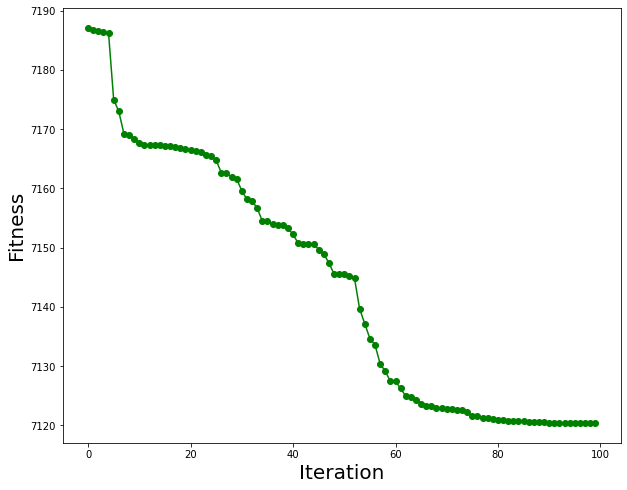

In [11]:
plt.plot(scores2, '-og')
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("Fitness", fontsize=20)

# Auto-MPG

In [12]:
auto_mpg = pd.read_csv("../data/mio3/auto-mpg.data-original",header=None, sep="\s+")
auto_mpg = auto_mpg.dropna(axis=0)
auto_mpg = auto_mpg.iloc[:,0:8]

from sklearn.model_selection import train_test_split
X_train_mpg, X_test_mpg, y_train_mpg, y_test_mpg = train_test_split(
    auto_mpg.iloc[:,1:8], auto_mpg.iloc[:,0], test_size=0.33, random_state=42)

In [13]:
mlp3 = MLP_with_GA(layers=[7, 20, 10, 1], population_size=30, num_generations=20, classif=False)

scores3 = mlp3.train(X_train_mpg, y_train_mpg)

Generation :  0
Generation :  1
Generation :  2
Generation :  3
Generation :  4
Generation :  5
Generation :  6
Generation :  7
Generation :  8
Generation :  9
Generation :  10
Generation :  11
Generation :  12
Generation :  13
Generation :  14
Generation :  15
Generation :  16
Generation :  17
Generation :  18
Generation :  19
The best solution fitness score is :  573.6709325237615


Text(0, 0.5, 'Fitness')

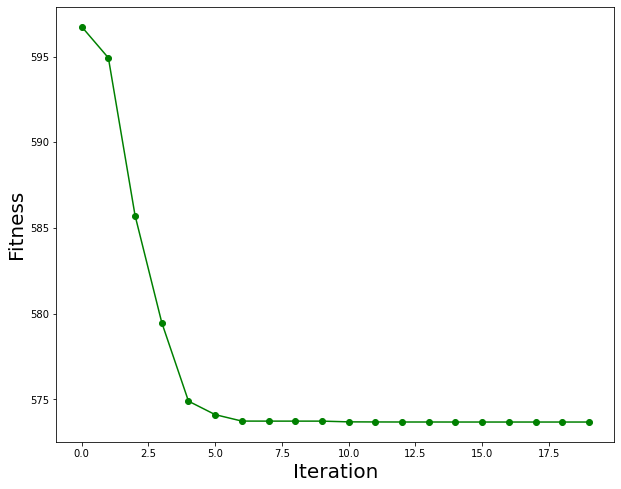

In [14]:
plt.plot(scores3, '-og')
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("Fitness", fontsize=20)